## モジュール・データ読み込み

In [32]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [33]:
SEED = 314
datasrc = "data/official/"
train = pd.read_csv(os.path.join(datasrc, "train.csv"), index_col=0)
x_train = train.drop(columns=["health"])
y_train = train["health"]
x_test = pd.read_csv(os.path.join(datasrc, "test.csv"), index_col=0)

## 大文字区切りで単語を分割する関数を定義

In [34]:
def split_string_by_uppercase(input_string):
    result = []
    current_word = ""
    if not type(input_string)==str:
        return result

    # Escape String "Other"
    for char in input_string:
        if char.isupper() and current_word:
            result.append(current_word)
            current_word = char
        else:
            current_word += char

    if current_word:
        result.append(current_word)

    return result

# 使用例
input_string = "SplitThisStringByUppercase"
print(input_string)
result = split_string_by_uppercase(input_string)
print(result)

SplitThisStringByUppercase
['Split', 'This', 'String', 'By', 'Uppercase']


## テストデータ固有の問題がないかを確認する

In [35]:
set(train.problems.unique()) - set(x_test.problems.unique())

set()

## 大文字区切りで単語を分割する

In [36]:
train.loc[:,"problems_list"] = train.problems.apply(split_string_by_uppercase)

In [37]:
problem_unique = set()
for problems in train.loc[:,"problems"].unique():
    for problem in split_string_by_uppercase(problems):
        problem_unique.add(problem)
problem_unique

{'Branch',
 'Grates',
 'Lights',
 'Metal',
 'Other',
 'Root',
 'Rope',
 'Sneakers',
 'Stones',
 'Trunk',
 'Wires'}

In [38]:
for unique_problem in problem_unique:
    train.loc[:,f"is_problem_{unique_problem}"] = train.loc[:,"problems_list"].apply(lambda x: unique_problem in x)
train

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,is_problem_Other,is_problem_Trunk,is_problem_Metal,is_problem_Lights,is_problem_Wires,is_problem_Root,is_problem_Stones,is_problem_Branch,is_problem_Sneakers,is_problem_Rope
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,False,False,False,False,False,False,False,False,False,False
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,False,False,False,False,False,False,False,False,False,False
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,False,False,False,True,False,False,True,True,False,False
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,False,False,False,False,False,False,False,False,False,False
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,2016-07-15,19,OnCurb,2,NaN,NaN,Damage,Volunteer,NaN,shingle oak,...,False,False,False,False,False,False,False,False,False,False
19980,2016-07-08,5,OnCurb,1,NaN,NaN,NoDamage,NYC Parks Staff,NaN,catalpa,...,False,False,False,False,False,False,False,False,False,False
19981,2015-08-20,21,OnCurb,0,NaN,NaN,Damage,Volunteer,NaN,English oak,...,False,False,False,False,False,False,False,False,False,False
19982,2016-06-20,4,OnCurb,1,1or2,NaN,NoDamage,NYC Parks Staff,NaN,littleleaf linden,...,False,False,False,False,False,False,False,False,False,False


### 問題の数を可視化
→Otherも1単語としてカウントされている為、他の単語と比べて多くなっている問題がある

In [39]:
train.loc[:,"problems_count"] = train.loc[:,"problems_list"].apply(len)
train.loc[:,"problems_count"].value_counts()

0     12243
2      2312
1      2219
3      1393
4       643
5       467
6       406
7       180
8        92
11       15
9        14
Name: problems_count, dtype: int64

<AxesSubplot: >

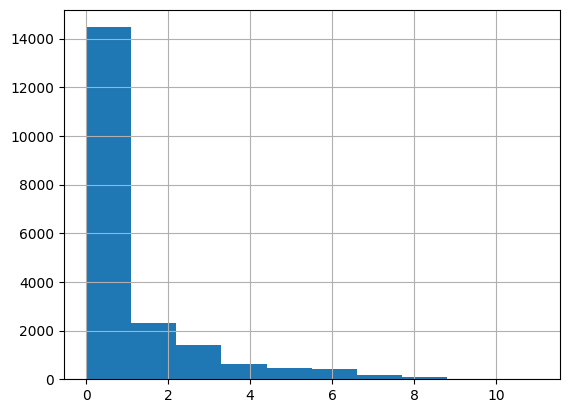

In [40]:
train.loc[:,"problems_list"].apply(len).hist()

In [41]:
train.groupby("health")["problems_count"].value_counts(normalize=True,).round(2).unstack()

problems_count,0,1,2,3,4,5,6,7,8,9,11
health,,,,,,,,,,,
0,0.57,0.12,0.12,0.08,0.03,0.03,0.02,0.01,0.01,0.0,0.0
1,0.62,0.11,0.12,0.07,0.03,0.02,0.02,0.01,0.00,0.0,0.0
2,0.62,0.08,0.10,0.07,0.04,0.04,0.03,0.02,0.01,0.0,NaN


## 木の部位ごとに問題があるのかの特徴量を作成

### 特徴量の可視化

In [42]:
parts_valuecounts = list()
parts_list = [
    "Branch",
    "Trunk",
    "Root",
]
for parts in parts_list:
    parts_valuecounts.append(train.loc[:,f"is_problem_{parts}"].value_counts().round(2))
pd.concat(parts_valuecounts, axis=1, keys=parts_list)

,Branch,Trunk,Root
False,16123,18498,18573
True,3861,1486,1411


In [43]:
train.groupby("health")["is_problem_Branch"].value_counts(normalize=True).unstack()

is_problem_Branch,False,True
health,,
0,0.778784,0.221216
1,0.813663,0.186337
2,0.793696,0.206304


In [44]:
train.groupby("health")["is_problem_Trunk"].value_counts(normalize=True).unstack()

is_problem_Trunk,False,True
health,,
0,0.923055,0.076945
1,0.927433,0.072567
2,0.898281,0.101719


In [45]:
train.groupby("health")["is_problem_Root"].value_counts(normalize=True).unstack()

is_problem_Root,False,True
health,,
0,0.918529,0.081471
1,0.932893,0.067107
2,0.905444,0.094556


In [46]:
train.groupby("health")[[f"is_problem_{parts}" for parts in parts_list]].value_counts(normalize=True,).round(2).unstack(level=0)

health                                                 0     1     2
is_problem_Branch is_problem_Trunk is_problem_Root                  
False             False            False            0.71  0.75  0.72
                                   True             0.03  0.03  0.03
                  True             False            0.02  0.03  0.03
                                   True             0.01  0.01  0.02
True              False            False            0.16  0.14  0.13
                                   True             0.02  0.01  0.03
                  True             False            0.02  0.02  0.03
                                   True             0.02  0.02  0.02

In [47]:
print("all",pd.DataFrame(train.health.value_counts(normalize=True), ).T)
train.groupby("health")[[f"is_problem_{parts}" for parts in parts_list]].value_counts().unstack(level=0).apply(lambda x: x/x.sum(), axis=1).round(2)

all                1         0         2
health  0.788181  0.176892  0.034928


health                                                 0     1     2
is_problem_Branch is_problem_Trunk is_problem_Root                  
False             False            False            0.17  0.80  0.03
                                   True             0.20  0.77  0.04
                  True             False            0.17  0.80  0.04
                                   True             0.21  0.72  0.07
True              False            False            0.21  0.76  0.03
                                   True             0.22  0.72  0.06
                  True             False            0.18  0.76  0.06
                                   True             0.19  0.77  0.04

木の部位の組み合わせや数について、ラベルを比較しても割合については差がない  
つまり、木の部位の組み合わせや数は問題の特徴量として有効でない可能性が高い。

### 特徴量の可視化

In [48]:
cause_valuecounts = list()
cause_list = [
        'Grates',
        'Lights',
        'Metal',
        'Other',
        'Rope',
        'Sneakers',
        'Stones',
        'Wires'
        ]
for cause in cause_list:
    cause_valuecounts.append(train.loc[:,f"is_problem_{cause}"].value_counts())
pd.DataFrame(cause_valuecounts, index=cause_list).T

,Grates,Lights,Metal,Other,Rope,Sneakers,Stones,Wires
False,19679,17268,19679,17026,19092,19974,15686,19092
True,305,2716,305,2958,892,10,4298,892


In [49]:
train.groupby("health")["is_problem_Grates"].value_counts(normalize=True).unstack()

is_problem_Grates,False,True
health,,
0,0.985007,0.014993
1,0.985080,0.014920
2,0.975645,0.024355


In [50]:
train.groupby("health")["is_problem_Lights"].value_counts(normalize=True).unstack()

is_problem_Lights,False,True
health,,
0,0.839038,0.160962
1,0.870484,0.129516
2,0.846705,0.153295


In [51]:
train.groupby("health")["is_problem_Metal"].value_counts(normalize=True).unstack()

is_problem_Metal,False,True
health,,
0,0.985007,0.014993
1,0.985080,0.014920
2,0.975645,0.024355


In [52]:
train.groupby("health")["is_problem_Other"].value_counts(normalize=True).unstack()

is_problem_Other,False,True
health,,
0,0.839604,0.160396
1,0.855374,0.144626
2,0.838109,0.161891


In [53]:
train.groupby("health")["is_problem_Rope"].value_counts(normalize=True).unstack()

is_problem_Rope,False,True
health,,
0,0.950495,0.049505
1,0.957780,0.042220
2,0.925501,0.074499


In [54]:
train.groupby("health")["is_problem_Sneakers"].value_counts(normalize=True).unstack()

is_problem_Sneakers,False,True
health,,
0,0.999434,0.000566
1,0.999492,0.000508
2,1.000000,NaN


In [55]:
train.groupby("health")["is_problem_Stones"].value_counts(normalize=True).unstack()

is_problem_Stones,False,True
health,,
0,0.755304,0.244696
1,0.791251,0.208749
2,0.792264,0.207736


In [56]:
train.groupby("health")["is_problem_Wires"].value_counts(normalize=True).unstack()

is_problem_Wires,False,True
health,,
0,0.950495,0.049505
1,0.957780,0.042220
2,0.925501,0.074499


In [57]:
train.groupby("health")[[f"is_problem_{cause}" for cause in cause_list]].value_counts().unstack(level=0).apply(lambda x: x/x.sum(), axis=1).round(2)

health                                                                                                                                           0  \
is_problem_Grates is_problem_Lights is_problem_Metal is_problem_Other is_problem_Rope is_problem_Sneakers is_problem_Stones is_problem_Wires         
False             False             False            False            False           False               False             False             0.16   
                                                                                                          True              False             0.20   
                                                                                      True                True              False             0.20   
                                                                      True            False               False             True              0.14   
                                                                                                          True              True              0.10   
                                                     True             False           False               False             False             0.18   
                                                                                                          True              False             0.20   
                                                                      True            False               False             True              0.17   
                                                                                                          True              True              0.16   
                  True              False            False            False           False               False             False             0.20   
                                                                                                          True              False             0.22   
                                                                      True            False               False             True              0.25   
                                                                                                          True              True              0.20   
                                                     True             False           False               False             False             0.20   
                                                                                                          True              False             0.17   
                                                                      True            False               False             True              0.26   
                                                                                                          True              True              0.26   
True              False             True             False            False           False               False             False             0.12   
                                                                                                          True              False             0.12   
                                                                      True            False               False             True              0.27   
                                                     True             False           False               False             False             0.25   
                                                                                                          True              False              NaN   
                  True              True             False            False           False               True              False             0.22   
                                                                      True            False               True              True              0.14   

health                                                                                             